### import

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from sklearn import svm
from sklearn.datasets import load_iris, make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

os.chdir("/data3/wuli/proj/wuli/cfRNA/brain/07_ML_in_Python/figure")

In [ ]:
path = "/data3/wuli/proj/wuli/cfRNA/brain/05_ML/data/data_train.csv"
train = pd.read_csv(path, encoding="utf-8")

X = train.iloc[:, 1:-1]
y = train.iloc[:, -1]
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

(267, 112)


In [ ]:
path = "/data3/wuli/proj/wuli/cfRNA/brain/05_ML/data/data_vaild.csv"
valid = pd.read_csv(path, encoding="utf-8")

X_valid = valid.iloc[:, 1:-1]
y_valid = valid.iloc[:, -1]
print(X_valid.shape)

(70, 112)


### 网格搜索+交叉验证

In [ ]:
classifier = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": np.arange(50, 201, 50).tolist(),
    "max_depth": np.arange(5, 21, 5).tolist(),
    "min_samples_split": np.arange(2, 11, 2).tolist(), 
    "min_samples_leaf": np.arange(2, 11, 2).tolist()
}

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=0, error_score='raise')
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [ ]:
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model found: {accuracy:.8f}")

cv_results = grid_search.cv_results_
mean_cv_accuracy = cv_results["mean_test_score"][grid_search.best_index_]
print(f"Mean cross-validated accuracy of the best model: {mean_cv_accuracy:.8f}")

Accuracy of the best model found: 0.83333333
Mean cross-validated accuracy of the best model: 0.77554113


### 最佳参数训练

In [ ]:
best_classifier = grid_search.best_estimator_
best_classifier.fit(X_train, y_train)
cv_scores = cross_val_score(best_classifier, X_train, y_train, cv=10)

print(f"10-fold cross-validation scores: {cv_scores}")
print(f"Average accuracy: {cv_scores.mean():.8f}")
print(f"Standard deviation: {cv_scores.std():.8f}")

train_accuracy = accuracy_score(y_train, best_classifier.predict(X_train))
print(f"Accuracy train: {train_accuracy:.8f}")
test_accuracy = accuracy_score(y_test, best_classifier.predict(X_test))
print(f"Accuracy test: {test_accuracy:.8f}")
valid_accuracy = accuracy_score(y_valid, best_classifier.predict(X_valid))
print(f"Accuracy valid: {valid_accuracy:.8f}")

10-fold cross-validation scores: [0.68181818 0.77272727 0.77272727 0.66666667 0.80952381 0.66666667
 0.66666667 0.80952381 0.71428571 0.71428571]
Average accuracy: 0.72748918
Standard deviation: 0.05575390
Accuracy train: 0.99530516
Accuracy test: 0.83333333
Accuracy valid: 0.74285714


### RFECV

In [ ]:
clf = grid_search.best_estimator_
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=clf, step=1, cv=cv, n_jobs=-1, verbose=0, 
    importance_getter='auto', scoring="accuracy", # roc_auc accuracy
    min_features_to_select=1,
)

rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Cross-validation scores for each number of selected features:", rfecv.grid_scores_)
print("Ranking of features:", rfecv.ranking_)

Optimal number of features : 34
Cross-validation scores for each number of selected features: [[0.74074074 0.74074074 0.55555556 ... 0.57692308 0.53846154 0.46153846]
 [0.66666667 0.59259259 0.51851852 ... 0.76923077 0.69230769 0.73076923]
 [0.66666667 0.62962963 0.51851852 ... 0.80769231 0.73076923 0.69230769]
 ...
 [0.85185185 0.74074074 0.62962963 ... 0.76923077 0.73076923 0.65384615]
 [0.7037037  0.77777778 0.66666667 ... 0.80769231 0.69230769 0.69230769]
 [0.81481481 0.66666667 0.7037037  ... 0.73076923 0.76923077 0.61538462]]
Ranking of features: [ 1 41  1 44  1 27  1 56  1  1 68 53 50  1  1  1  6 60 75 39 26 36  9  1
  7 70  1  1  1 49 37 57 48 19 10  1 74  1 22  1  1  2 24 69  3 72 35  1
  1  1  1 13  1 59 30 62  8 79 42 46 15  5 31  1 28  1 16 29  1 63 33 23
 58 76 20  1  1 67 71  1 32 21  1 18 73 65 64 14 17 40 77 43 25 45  1 11
 78  1 47 61 51 52 12 38 66  1 54 34  1  1  4 55]


/data2/wuli/software/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mean_scores = np.mean(rfecv.grid_scores_, axis=1)
idx = np.where(rfecv.ranking_ == 1)[0]
importances = mean_scores[idx]
print(importances)

genes = train.iloc[:, 1:-1].columns[rfecv.ranking_ == 1]
print(genes)

feature_importance_df = pd.DataFrame({
    'Feature': genes, 
    'Importance': importances
})
feature_importance_df.to_csv('feature_importances.csv', index=False)

[0.60213675 0.67863248 0.68176638 0.67037037 0.6968661  0.70413105
 0.70769231 0.7454416  0.72307692 0.7454416  0.72663818 0.7002849
 0.74501425 0.72649573 0.7522792  0.70740741 0.72250712 0.74529915
 0.73404558 0.73746439 0.73789174 0.7525641  0.74501425 0.7525641
 0.73404558 0.70754986 0.73048433 0.71125356 0.74159544 0.73774929
 0.73376068 0.72250712 0.74173789 0.72279202]
Index(['ACSL1', 'ANPEP', 'APLNR', 'ARL1', 'BCL2', 'BCL6', 'CCT5', 'CREB5',
       'CYTH1', 'EZR', 'FLOT2', 'GCA', 'GGA2', 'HSPA8', 'IKZF1', 'LAMTOR4',
       'LBH', 'MNDA', 'MRPS23', 'MTATP6P1', 'MTRNR2L12', 'NEAT1', 'PTPN6',
       'RAB11FIP4', 'RBM47', 'RPL3P4', 'RPL6P27', 'RPS17', 'RUNX2', 'SNX30',
       'STIP1', 'TSPYL1', 'YBEY', 'ZBTB18'],
      dtype='object')


/data2/wuli/software/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


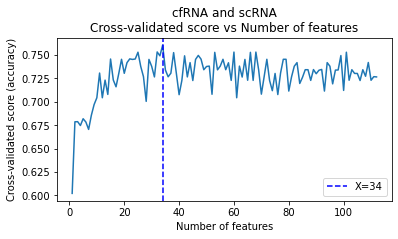

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.mean(rfecv.grid_scores_, axis=1))
plt.xlabel('Number of features')
plt.ylabel('Cross-validated score (accuracy)')
plt.title('cfRNA and scRNA\nCross-validated score vs Number of features')
plt.axvline(x=34, linestyle="--", color="blue", label="X=34")  # 添加x=6的虚线
plt.legend() 
plt.savefig('cross_val_score_vs_features_cfRNA.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

### 特征选取后训练

In [50]:
gene = train.iloc[:, 1:-1].columns
selected_genes = gene[rfecv.ranking_ == 1]
selected_genes

Index(['ACSL1', 'ANPEP', 'APLNR', 'ARL1', 'BCL2', 'BCL6', 'CCT5', 'CREB5',
       'CYTH1', 'EZR', 'FLOT2', 'GCA', 'GGA2', 'HSPA8', 'IKZF1', 'LAMTOR4',
       'LBH', 'MNDA', 'MRPS23', 'MTATP6P1', 'MTRNR2L12', 'NEAT1', 'PTPN6',
       'RAB11FIP4', 'RBM47', 'RPL3P4', 'RPL6P27', 'RPS17', 'RUNX2', 'SNX30',
       'STIP1', 'TSPYL1', 'YBEY', 'ZBTB18'],
      dtype='object')

In [51]:
genes = ['ACSL1', 'ANPEP', 'APLNR', 'ARL1', 'BCL2', 'BCL6', 'CCT5', 'CREB5',
       'CYTH1', 'EZR', 'FLOT2', 'GCA', 'GGA2', 'HSPA8', 'IKZF1', 'LAMTOR4',
       'LBH', 'MNDA', 'MRPS23', 'MTATP6P1', 'MTRNR2L12', 'NEAT1', 'PTPN6',
       'RAB11FIP4', 'RBM47', 'RPL3P4', 'RPL6P27', 'RPS17', 'RUNX2', 'SNX30',
       'STIP1', 'TSPYL1', 'YBEY', 'ZBTB18', "group"]

In [ ]:
path = "/data3/wuli/proj/wuli/cfRNA/brain/05_ML/data/data_train.csv"
train = pd.read_csv(path, encoding="utf-8")
train = pd.DataFrame(train)
train = train.iloc[:, 1:][genes]

X = train.iloc[:, :-1] 
y = train.iloc[:, -1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
print(X_train.shape)

      ACSL1      ANPEP     APLNR      ARL1      BCL2      BCL6      CCT5  \
0  9.259294  10.839499  8.688148  8.289144  9.590462  9.105031  8.674277   
1  9.010935   7.828568  7.368559  8.628650  9.595168  8.384548  9.218307   
2  9.105818   8.382742  7.885146  8.533808  9.388066  8.628150  8.849918   

       CREB5      CYTH1        EZR  ...    RPL3P4   RPL6P27      RPS17  \
0  10.098720   9.405623   9.570477  ...  6.264923  6.445541   8.003871   
1   8.075056  10.015300  11.086361  ...  8.042499  8.087862  10.994655   
2   9.417980   9.602338  10.563413  ...  6.882991  7.735704  10.300014   

      RUNX2     SNX30     STIP1    TSPYL1      YBEY    ZBTB18  group  
0  9.832109  9.374378  9.094718  8.475620  7.645173  9.303386      1  
1  8.180242  8.469153  9.169231  9.557630  7.162882  9.595168      1  
2  8.009937  8.453451  8.643273  9.438725  7.029253  9.614531      1  

[3 rows x 35 columns]
(213, 34)


In [ ]:
path = "/data3/wuli/proj/wuli/cfRNA/brain/05_ML/data/data_vaild.csv"
valid = pd.read_csv(path, encoding="utf-8")
valid = valid.iloc[:, 1:][genes]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]
print(X_valid.shape)

(70, 34)


### 最终结果

#### 随机森林

Accuracy Train: 0.956807511737089
Accuracy Test: 0.8222222222222222
Accuracy Valid: 0.6685714285714285


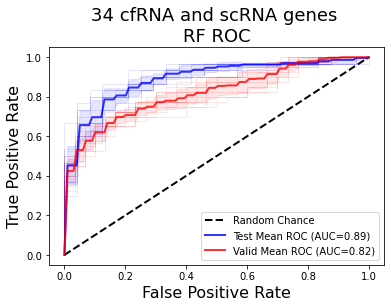

In [ ]:
classifier = grid_search.best_estimator_
n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

tprs_train = []
aucs_train = []
accuracy_train = 0

tprs_valid = []
aucs_valid = []
accuracy_valid = 0

tprs_test = []
aucs_test = []
accuracy_test = 0

mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Random Chance", alpha=1)

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_train.iloc[train], y_train.iloc[train])

    ### Train dataset -------------------------------------
    curr_score = classifier.score(X_train, y_train)
    accuracy_train = accuracy_train + curr_score

    y_score_train = classifier.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    viz_train = roc_auc_score(y_train, y_score_train)

    interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
    interp_tpr_train[0] = 0.0

    tprs_train.append(interp_tpr_train)
    aucs_train.append(viz_train)

    ### Validation dataset -------------------------------------
    curr_score = classifier.score(X_valid, y_valid)
    accuracy_valid = accuracy_valid + curr_score

    y_score_valid = classifier.predict_proba(X_valid)[:, 1]
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_score_valid)
    viz_valid = roc_auc_score(y_valid, y_score_valid)

    interp_tpr_valid = np.interp(mean_fpr, fpr_valid, tpr_valid)
    interp_tpr_valid[0] = 0.0

    tprs_valid.append(interp_tpr_valid)
    aucs_valid.append(viz_valid)

    ax.plot(fpr_valid, tpr_valid, lw=1, alpha=0.1, color="r")

    ### Test dataset -------------------------------------
    curr_score = classifier.score(X_test, y_test)
    accuracy_test = accuracy_test + curr_score

    y_score_test = classifier.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    viz_test = roc_auc_score(y_test, y_score_test)

    interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
    interp_tpr_test[0] = 0.0

    tprs_test.append(interp_tpr_test)
    aucs_test.append(viz_test)

    ax.plot(fpr_test, tpr_test, lw=1, alpha=0.1, color="b")

accuracy_train = accuracy_train / n_splits
accuracy_valid = accuracy_valid / n_splits
accuracy_test = accuracy_test / n_splits
print("Accuracy Train:", accuracy_train)
print("Accuracy Test:", accuracy_test)
print("Accuracy Valid:", accuracy_valid)

mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_valid = np.mean(tprs_valid, axis=0)
mean_tpr_test = np.mean(tprs_test, axis=0)

mean_auc_train = auc(mean_fpr, mean_tpr_train)
mean_auc_valid = auc(mean_fpr, mean_tpr_valid)
mean_auc_test = auc(mean_fpr, mean_tpr_test)

std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper_train = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower_train = np.maximum(mean_tpr_train - std_tpr_train, 0)

std_tpr_valid = np.std(tprs_valid, axis=0)
tprs_upper_valid = np.minimum(mean_tpr_valid + std_tpr_valid, 1)
tprs_lower_valid = np.maximum(mean_tpr_valid - std_tpr_valid, 0)
ax.fill_between(mean_fpr, tprs_lower_valid, tprs_upper_valid, color="r", alpha=0.1)

std_tpr_test = np.std(tprs_test, axis=0)
tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
ax.fill_between(mean_fpr, tprs_lower_test, tprs_upper_test, color="b", alpha=0.1)

ax.plot(mean_fpr, mean_tpr_test, color="b", lw=2, alpha=0.8, label=r"Test Mean ROC (AUC=%0.2f)" % (mean_auc_test),)
ax.plot(mean_fpr, mean_tpr_valid, color="r", lw=2, alpha=0.8, label=r"Valid Mean ROC (AUC=%0.2f)" % (mean_auc_valid),)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_title("34 cfRNA and scRNA genes \nRF ROC", fontsize=18)
ax.legend(loc="lower right")
plt.savefig('cross_val_score_vs_features_RF.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

#### SVM

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

classifier = svm.SVC(probability=True)
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.1, 0.01, 0.001],
    # 'kernel': ['linear', 'rbf', 'poly']
    "kernel": ["linear"]
}

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42) # Mean cross-validated accuracy of the best model: 0.69956710
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model found: {accuracy:.8f}")

cv_results = grid_search.cv_results_
mean_cv_accuracy = cv_results["mean_test_score"][grid_search.best_index_]
print(f"Mean cross-validated accuracy of the best model: {mean_cv_accuracy:.8f}")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy of the best model found: 0.75925926
Mean cross-validated accuracy of the best model: 0.72445887


Accuracy Train: 0.8131455399061032
Accuracy Test: 0.7611111111111113
Accuracy Valid: 0.6714285714285715


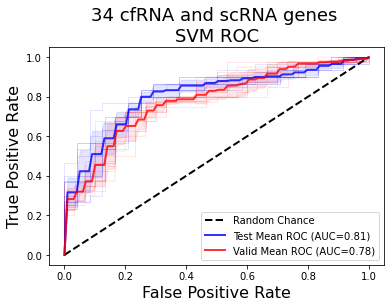

In [ ]:
classifier = grid_search.best_estimator_
n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

tprs_train = []
aucs_train = []
accuracy_train = 0

tprs_valid = []
aucs_valid = []
accuracy_valid = 0

tprs_test = []
aucs_test = []
accuracy_test = 0

mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Random Chance", alpha=1)

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_train.iloc[train], y_train.iloc[train])

    ### Train dataset -------------------------------------
    curr_score = classifier.score(X_train, y_train)
    accuracy_train = accuracy_train + curr_score

    y_score_train = classifier.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    viz_train = roc_auc_score(y_train, y_score_train)

    interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
    interp_tpr_train[0] = 0.0

    tprs_train.append(interp_tpr_train)
    aucs_train.append(viz_train)

    ### Validation dataset -------------------------------------
    curr_score = classifier.score(X_valid, y_valid)
    accuracy_valid = accuracy_valid + curr_score

    y_score_valid = classifier.predict_proba(X_valid)[:, 1]
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_score_valid)
    viz_valid = roc_auc_score(y_valid, y_score_valid)

    interp_tpr_valid = np.interp(mean_fpr, fpr_valid, tpr_valid)
    interp_tpr_valid[0] = 0.0

    tprs_valid.append(interp_tpr_valid)
    aucs_valid.append(viz_valid)

    ax.plot(fpr_valid, tpr_valid, lw=1, alpha=0.1, color="r")

    ### Test dataset -------------------------------------
    curr_score = classifier.score(X_test, y_test)
    accuracy_test = accuracy_test + curr_score

    y_score_test = classifier.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    viz_test = roc_auc_score(y_test, y_score_test)

    interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
    interp_tpr_test[0] = 0.0

    tprs_test.append(interp_tpr_test)
    aucs_test.append(viz_test)

    ax.plot(fpr_test, tpr_test, lw=1, alpha=0.1, color="b")

accuracy_train = accuracy_train / n_splits
accuracy_valid = accuracy_valid / n_splits
accuracy_test = accuracy_test / n_splits
print("Accuracy Train:", accuracy_train)
print("Accuracy Test:", accuracy_test)
print("Accuracy Valid:", accuracy_valid)

mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_valid = np.mean(tprs_valid, axis=0)
mean_tpr_test = np.mean(tprs_test, axis=0)

mean_auc_train = auc(mean_fpr, mean_tpr_train)
mean_auc_valid = auc(mean_fpr, mean_tpr_valid)
mean_auc_test = auc(mean_fpr, mean_tpr_test)

std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper_train = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower_train = np.maximum(mean_tpr_train - std_tpr_train, 0)

std_tpr_valid = np.std(tprs_valid, axis=0)
tprs_upper_valid = np.minimum(mean_tpr_valid + std_tpr_valid, 1)
tprs_lower_valid = np.maximum(mean_tpr_valid - std_tpr_valid, 0)
ax.fill_between(mean_fpr, tprs_lower_valid, tprs_upper_valid, color="r", alpha=0.1)

std_tpr_test = np.std(tprs_test, axis=0)
tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
ax.fill_between(mean_fpr, tprs_lower_test, tprs_upper_test, color="b", alpha=0.1)

ax.plot(mean_fpr, mean_tpr_test, color="b", lw=2, alpha=0.8, label=r"Test Mean ROC (AUC=%0.2f)" % (mean_auc_test),)
ax.plot(mean_fpr, mean_tpr_valid, color="r", lw=2, alpha=0.8, label=r"Valid Mean ROC (AUC=%0.2f)" % (mean_auc_valid),)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_title("34 cfRNA and scRNA genes \nSVM ROC", fontsize=18)
ax.legend(loc="lower right")
plt.savefig('cross_val_score_vs_features_SVM.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

#### 逻辑回归分类

In [ ]:
classifier = LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000) # 选择 'liblinear' 或 'sag' 作为求解器
param_grid = {"C": [0.1, 1.0, 10.0]}
n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=0, error_score='raise')
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 1.0}


Accuracy Train: 0.7948356807511738
Accuracy Test: 0.7648148148148148
Accuracy Valid: 0.7214285714285714


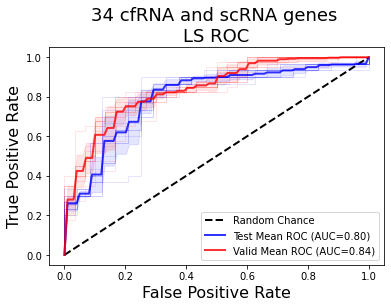

In [ ]:
classifier = grid_search.best_estimator_

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

tprs_train = []
aucs_train = []
accuracy_train = 0

tprs_valid = []
aucs_valid = []
accuracy_valid = 0

tprs_test = []
aucs_test = []
accuracy_test = 0

mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Random Chance", alpha=1)

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_train.iloc[train], y_train.iloc[train])

    ### Train dataset -------------------------------------
    curr_score = classifier.score(X_train, y_train)
    accuracy_train = accuracy_train + curr_score

    y_score_train = classifier.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    viz_train = roc_auc_score(y_train, y_score_train)

    interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
    interp_tpr_train[0] = 0.0

    tprs_train.append(interp_tpr_train)
    aucs_train.append(viz_train)

    ### Validation dataset -------------------------------------
    curr_score = classifier.score(X_valid, y_valid)
    accuracy_valid = accuracy_valid + curr_score

    y_score_valid = classifier.predict_proba(X_valid)[:, 1]
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_score_valid)
    viz_valid = roc_auc_score(y_valid, y_score_valid)

    interp_tpr_valid = np.interp(mean_fpr, fpr_valid, tpr_valid)
    interp_tpr_valid[0] = 0.0

    tprs_valid.append(interp_tpr_valid)
    aucs_valid.append(viz_valid)

    ax.plot(fpr_valid, tpr_valid, lw=1, alpha=0.1, color="r")

    ### Test dataset -------------------------------------
    curr_score = classifier.score(X_test, y_test)
    accuracy_test = accuracy_test + curr_score

    y_score_test = classifier.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    viz_test = roc_auc_score(y_test, y_score_test)

    interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
    interp_tpr_test[0] = 0.0

    tprs_test.append(interp_tpr_test)
    aucs_test.append(viz_test)

    ax.plot(fpr_test, tpr_test, lw=1, alpha=0.1, color="b")

accuracy_train = accuracy_train / n_splits
accuracy_valid = accuracy_valid / n_splits
accuracy_test = accuracy_test / n_splits
print("Accuracy Train:", accuracy_train)
print("Accuracy Test:", accuracy_test)
print("Accuracy Valid:", accuracy_valid)

mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_valid = np.mean(tprs_valid, axis=0)
mean_tpr_test = np.mean(tprs_test, axis=0)

mean_auc_train = auc(mean_fpr, mean_tpr_train)
mean_auc_valid = auc(mean_fpr, mean_tpr_valid)
mean_auc_test = auc(mean_fpr, mean_tpr_test)

std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper_train = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower_train = np.maximum(mean_tpr_train - std_tpr_train, 0)

std_tpr_valid = np.std(tprs_valid, axis=0)
tprs_upper_valid = np.minimum(mean_tpr_valid + std_tpr_valid, 1)
tprs_lower_valid = np.maximum(mean_tpr_valid - std_tpr_valid, 0)
ax.fill_between(mean_fpr, tprs_lower_valid, tprs_upper_valid, color="r", alpha=0.1)

std_tpr_test = np.std(tprs_test, axis=0)
tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
ax.fill_between(mean_fpr, tprs_lower_test, tprs_upper_test, color="b", alpha=0.1)

ax.plot(mean_fpr, mean_tpr_test, color="b", lw=2, alpha=0.8, label=r"Test Mean ROC (AUC=%0.2f)" % (mean_auc_test),)
ax.plot(mean_fpr, mean_tpr_valid, color="r", lw=2, alpha=0.8, label=r"Valid Mean ROC (AUC=%0.2f)" % (mean_auc_valid),)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_title("34 cfRNA and scRNA genes \nLS ROC", fontsize=18)
ax.legend(loc="lower right")
plt.savefig('cross_val_score_vs_features_LS.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()